In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
plt.style.use("ggplot")
START_DATE = {
  'US': '1/22/20'
}
country = "US"
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
country_df = df[df['Country/Region'] == country]
data = country_df.iloc[0].loc[START_DATE[country]:]
data = data.to_numpy().astype(float)
data = data/1e4

## Raw Data

1/22/2020 - 5/3/2020, US confirmed cases (source: HDX)

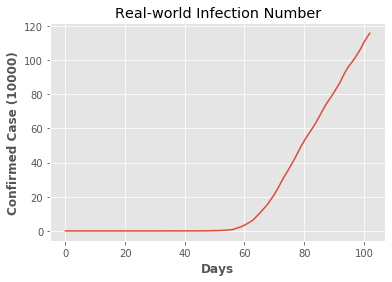

In [2]:
plt.plot(data)
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Confirmed Case (10000)",fontweight="bold")
plt.title("Real-world Infection Number")
plt.savefig("figures/real_number.jpg", bbox_inches='tight')

In [3]:
def seqirmodel(y, t, N, beta, delta, theta, alpha, gamma):    
    S,E,Q,I,R = y
    dsdt = -beta * S * I / N
    dedt = beta * S * I / N - delta * E - alpha * E
    dqdt = delta * E - theta * Q
    didt = theta * Q + alpha * E - gamma * I
    drdt = gamma * I
    return dsdt, dedt, dqdt, didt, drdt

# Initial simulation

In [4]:
s0 = 3.3e4
e0 = 0
q0 = 0
i0 = 1e-4
r0 = 0
N = 3.3e4
t = np.arange(0,200,1)
y0 = [s0, e0, q0, i0, r0]

# Find the optimal set of parameters

In [5]:
def loss(params, data):
    size = len(data)
    beta, delta, theta, alpha, gamma = params
    N = 3.3e4
    def SEQIR(y, t):
        S = y[0]
        E = y[1]
        Q = y[2]
        I = y[3]
        R = y[4]
        dsdt = -beta * S * I / N
        dedt = beta * S * I / N - delta * E - alpha * E
        dqdt = delta * E - theta * Q
        didt = theta * Q + alpha * E - gamma * I
        drdt = gamma * I
        return dsdt, dedt, dqdt, didt, drdt
    solution = odeint(SEQIR, y0, np.arange(0, size, 1))
    return np.sqrt(np.mean((solution[:,3] - data)**2))

bnds = ((1,20), (0.001, 0.8), (0.001, 1), (0.01,1), (0.01,0.9))
optimal = minimize(loss, [1, 0.01, 0.01, 0.01, 0.01], args = (data), method='SLSQP', bounds = bnds)

In [6]:
beta_opt, delta_opt, theta_opt, alpha_opt, gamma_opt = optimal.x

In [7]:
optimal.x

array([4.45631887e+00, 7.99999809e-01, 1.00000114e-03, 2.89688402e-01,
       8.99706298e-01])

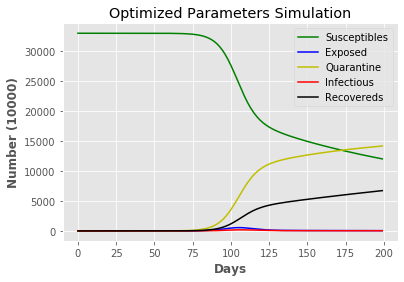

In [17]:
result = odeint(seqirmodel, y0, t, args=(N, beta_opt, delta_opt, theta_opt, alpha_opt, gamma_opt))
plt.plot(result[:,0], '-g', label='Susceptibles')
plt.plot(result[:,1], '-b', label='Exposed')
plt.plot(result[:,2], '-y', label='Quarantine')
plt.plot(result[:,3], '-r', label='Infectious')
plt.plot(result[:,4], '-k', label='Recovereds')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/seqir_opt_all.jpg", bbox_inches='tight')

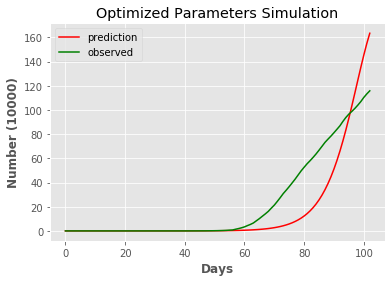

In [13]:
pred_inf = result[:,3][0:103]
plt.plot(pred_inf, '-r', label='prediction')
plt.plot(data, 'g', label = 'observed')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/seqir_opt_cmp.jpg", bbox_inches='tight')

In [14]:
from sklearn.metrics import r2_score
sir_r2 = r2_score(data, pred_inf)
print("The optimal r2 score for simple SIR model is:", sir_r2)

The optimal r2 score for simple SIR model is: 0.7327094167178292


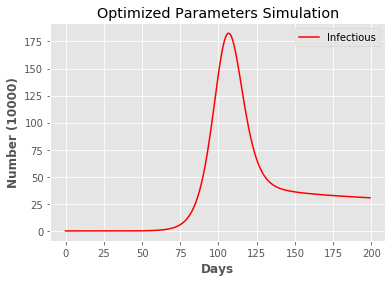

In [15]:
plt.plot(result[:,3], '-r', label='Infectious')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/seqir_opt_inf.jpg", bbox_inches='tight')

In [20]:
optimal.x

array([4.45631887e+00, 7.99999809e-01, 1.00000114e-03, 2.89688402e-01,
       8.99706298e-01])

## Prediction

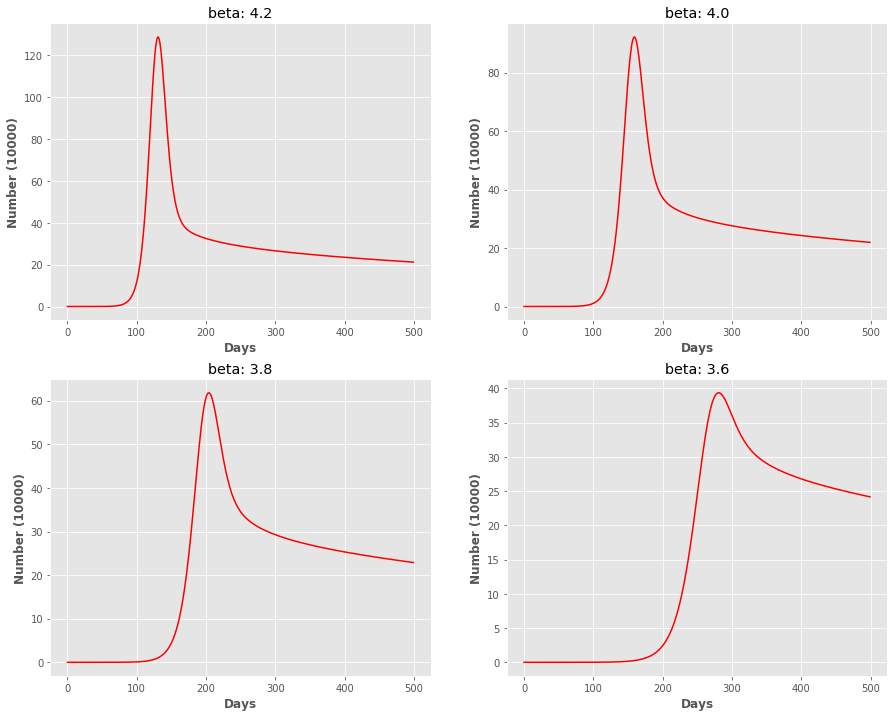

In [74]:
delta = delta_opt
theta = theta_opt
alpha = alpha_opt
gamma = gamma_opt
t = np.arange(0,500,1)
betas = [4.2, 4.0, 3.8, 3.6]
fig = plt.figure(figsize=(15,12))
i = 1
for beta in betas:
    result = odeint(seqirmodel, y0, t, args=(N, beta, delta, theta, alpha, gamma))
    fig.add_subplot(2, 2, i)
    plt.plot(result[:,3], '-r')
    plt.xlabel("Days",fontweight="bold")
    plt.ylabel("Number (10000)",fontweight="bold")
    title = "beta: " + str(beta)
    plt.title(title)
    i += 1
plt.savefig("figures/seqir_pred_beta.jpg", bbox_inches='tight')

Text(0.5, 1.0, 'Optimized Parameters Simulation')

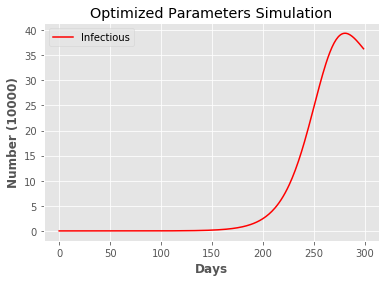

In [84]:
beta = 3.6
t = np.arange(0,300,1)
result = odeint(seqirmodel, y0, t, args=(N, beta, delta, theta, alpha, gamma))
plt.plot(result[:,3], '-r', label='Infectious')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")